## VAE

### AutoEncoder

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='../chap13/data', train=True, transform=transform, download=True)

test_dataset = datasets.MNIST(root='../chap13/data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=False)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [30]:
class Encoder(nn.Module):    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
    
class Decoder(nn.Module):    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [31]:
encoder = Encoder(encoded_space_dim=4, fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=4, fc2_input_dim=128)
encoder.to(device)
decoder.to(device)

params_to_optimize = [{'params': encoder.parameters()},
                     {'params': decoder.parameters()}
                     ]
optim = torch.optim.Adam(params_to_optimize, lr=0.001, weight_decay=1e-05)
loss_fn = torch.nn.MSELoss()

In [32]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer, noise_factor=0.3):
    encoder.train()
    decoder.train()
    train_loss = []
    for image_batch, _ in dataloader:
        image_noisy = add_noise(image_batch, noise_factor)
        image_noisy = image_noisy.to(device)
        encoded_data = encoder(image_noisy)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data,image_noisy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

In [33]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn, noise_factor=0.3):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)
            encoded_data = encoder(image_batch)
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [34]:
def add_noise(inputs, noise_factor=0.3):
    noisy = inputs + torch.randn_like(inputs)*noise_factor
    noisy = torch.clip(noisy,0.,1.)
    return noisy

In [35]:
# from matplotlib import font_manager
# font_fname= 'C:/Windows?Fonts/malgun.ttf'
# font_family = font_manager.FontProperties(fname=font_fname).get_name()
# plt.rcParams['font.family']=font_family

In [36]:
def plot_ae_outputs(encoder,decoder,n=5,noise_factor=0.3):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
        ax = plt.subplot(3,n,i+1)
        img = test_dataset[i][0].unsqueeze(0)
        image_noisy = add_noise(img,noise_factor)     
        image_noisy = image_noisy.to(device)

        encoder.eval()
        decoder.eval()

        with torch.no_grad():
            rec_img  = decoder(encoder(image_noisy))

        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('원래 이미지')
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('노이즈가 적용되어 손상된 이미지')

        ax = plt.subplot(3, n, i + 1 + n + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('재구성된 이미지')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show()

EPOCH 1/30

 EPOCH 1/30 	 train loss 0.076 	 val loss 0.049


C:\Users\Seungyun\anaconda3\envs\torch_book\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Seungyun\anaconda3\envs\torch_book\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Seungyun\anaconda3\envs\torch_book\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Seungyun\anaconda3\envs\torch_book\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Seungyun\anaconda3\envs\torch_book\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) mi

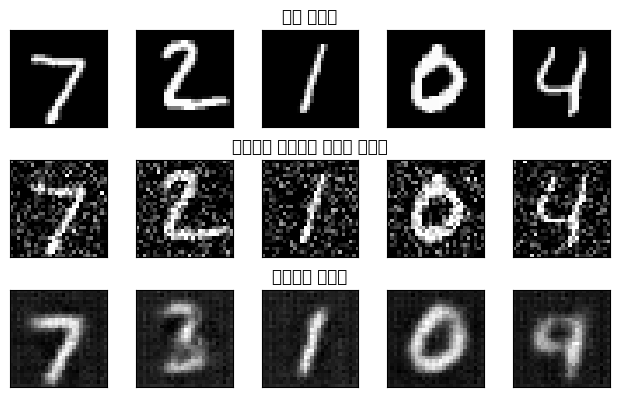

EPOCH 2/30

 EPOCH 2/30 	 train loss 0.055 	 val loss 0.044


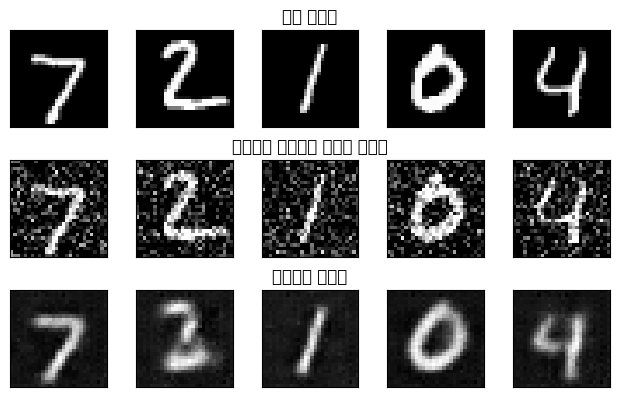

EPOCH 3/30

 EPOCH 3/30 	 train loss 0.053 	 val loss 0.043


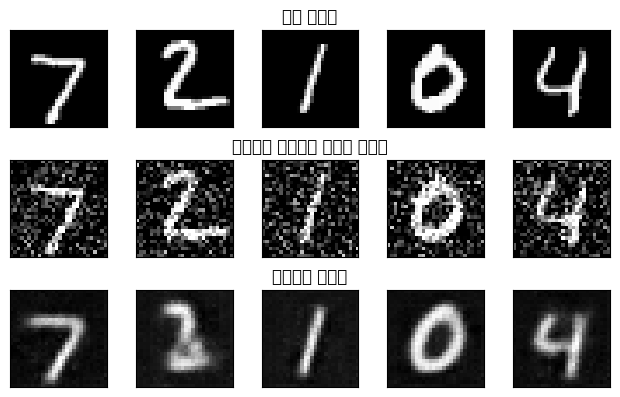

EPOCH 4/30

 EPOCH 4/30 	 train loss 0.052 	 val loss 0.042


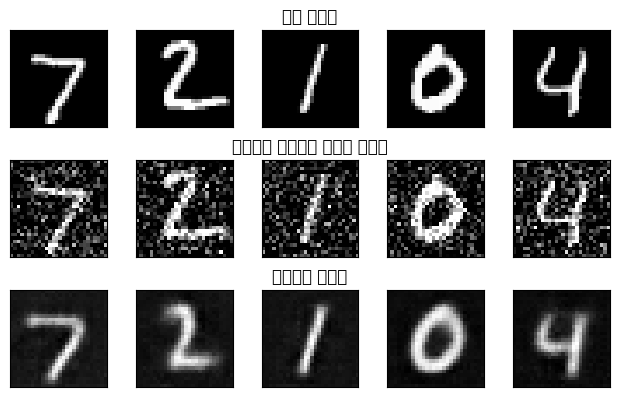

EPOCH 5/30

 EPOCH 5/30 	 train loss 0.052 	 val loss 0.041


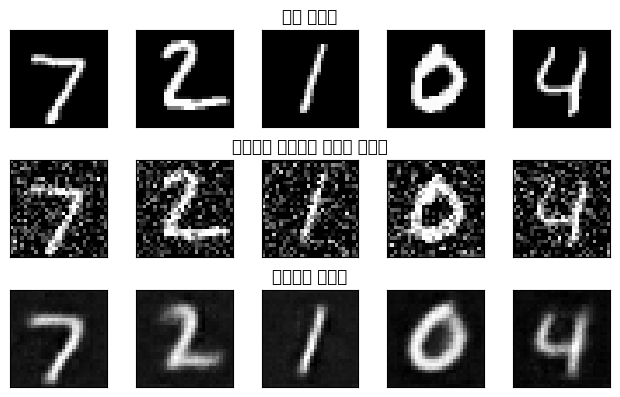

EPOCH 6/30

 EPOCH 6/30 	 train loss 0.051 	 val loss 0.040


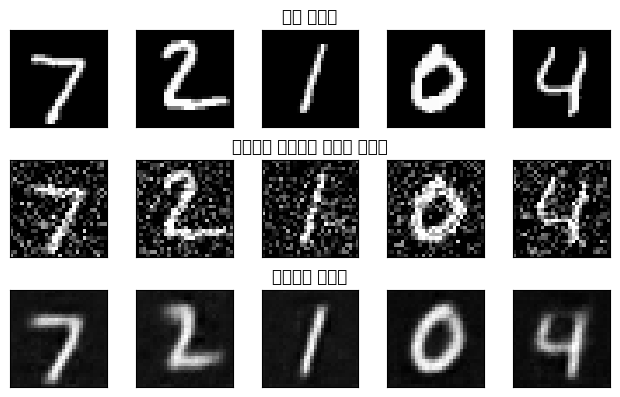

EPOCH 7/30

 EPOCH 7/30 	 train loss 0.051 	 val loss 0.040


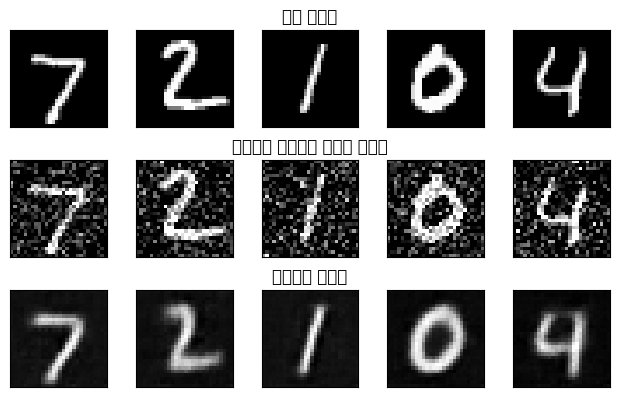

EPOCH 8/30

 EPOCH 8/30 	 train loss 0.051 	 val loss 0.040


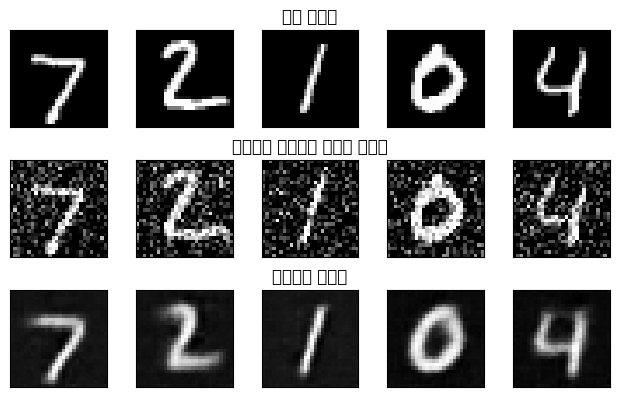

EPOCH 9/30

 EPOCH 9/30 	 train loss 0.051 	 val loss 0.040


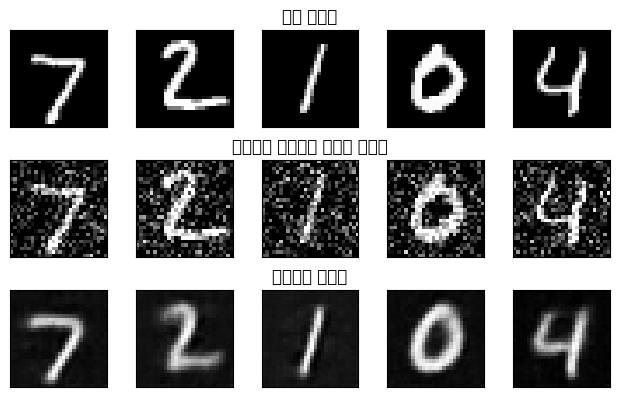

EPOCH 10/30

 EPOCH 10/30 	 train loss 0.050 	 val loss 0.039


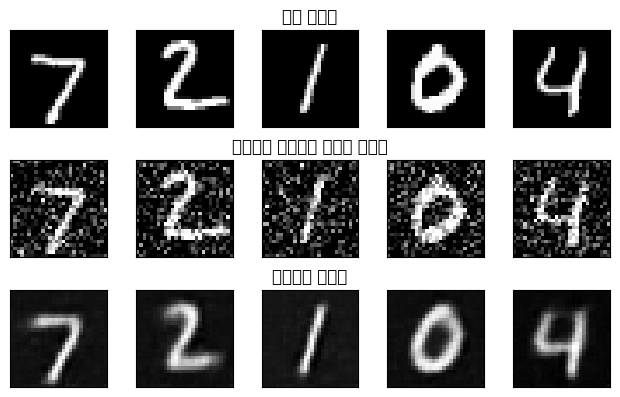

EPOCH 11/30

 EPOCH 11/30 	 train loss 0.050 	 val loss 0.039


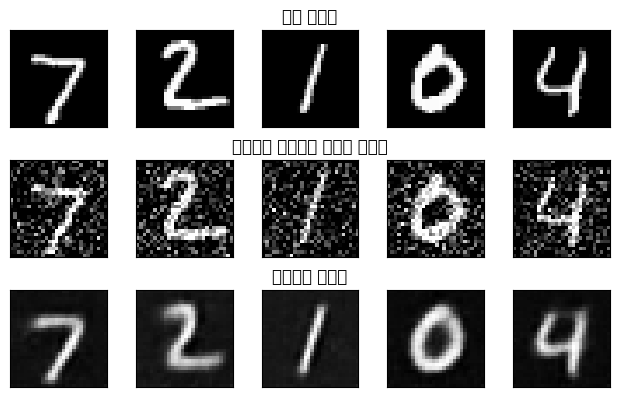

EPOCH 12/30

 EPOCH 12/30 	 train loss 0.050 	 val loss 0.040


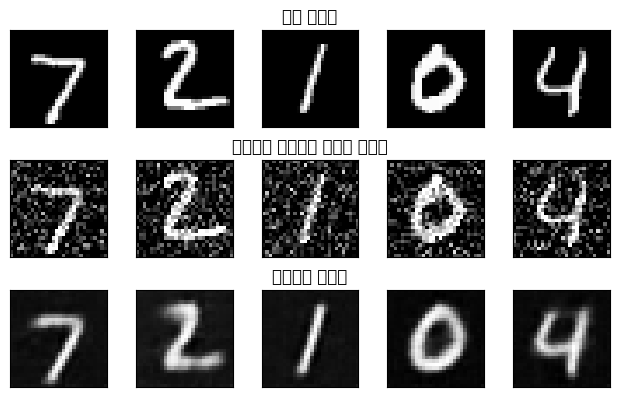

EPOCH 13/30

 EPOCH 13/30 	 train loss 0.050 	 val loss 0.039


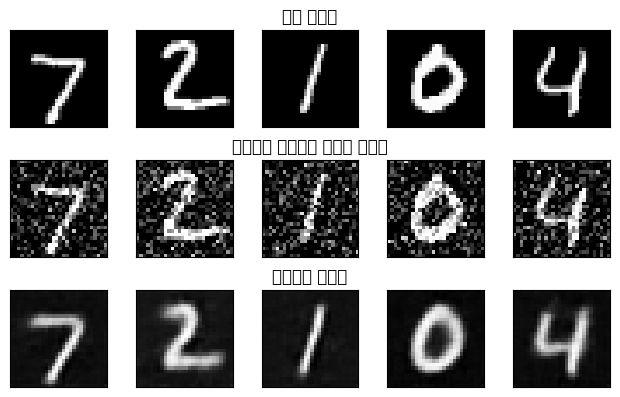

EPOCH 14/30

 EPOCH 14/30 	 train loss 0.050 	 val loss 0.039


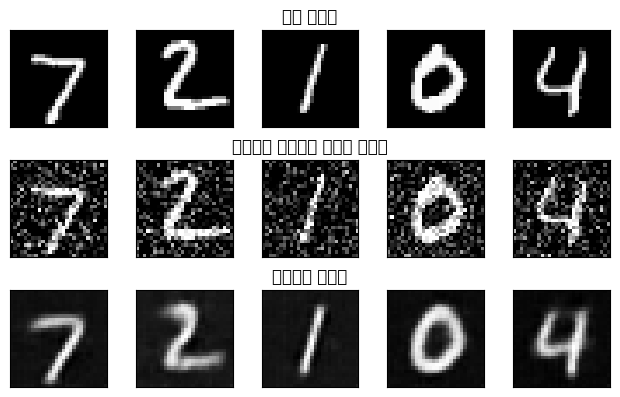

EPOCH 15/30

 EPOCH 15/30 	 train loss 0.050 	 val loss 0.039


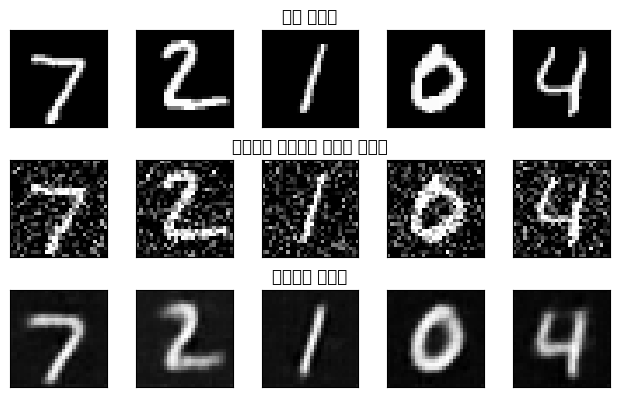

EPOCH 16/30

 EPOCH 16/30 	 train loss 0.050 	 val loss 0.038


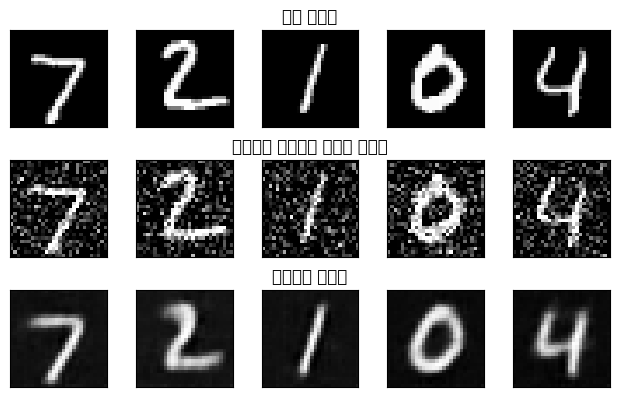

EPOCH 17/30

 EPOCH 17/30 	 train loss 0.050 	 val loss 0.039


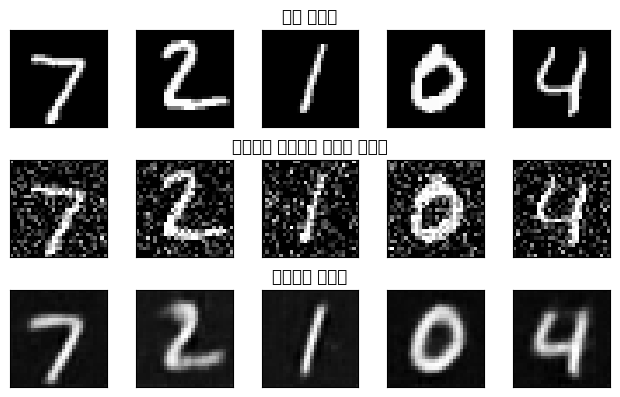

EPOCH 18/30

 EPOCH 18/30 	 train loss 0.050 	 val loss 0.039


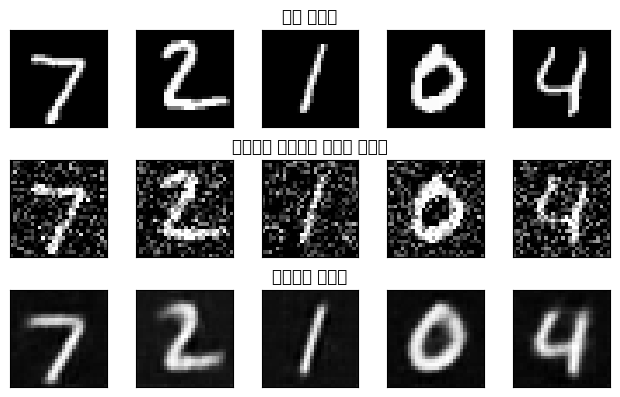

EPOCH 19/30

 EPOCH 19/30 	 train loss 0.050 	 val loss 0.038


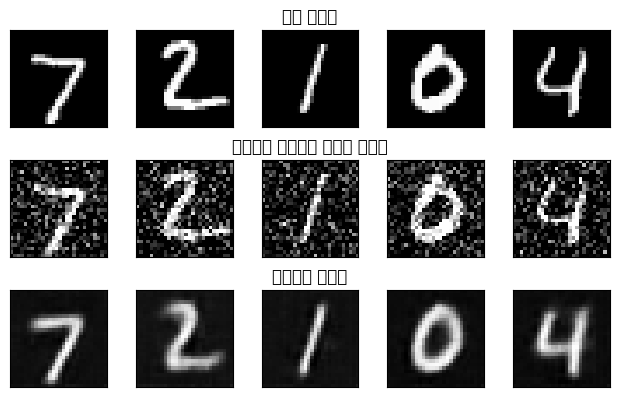

EPOCH 20/30

 EPOCH 20/30 	 train loss 0.050 	 val loss 0.039


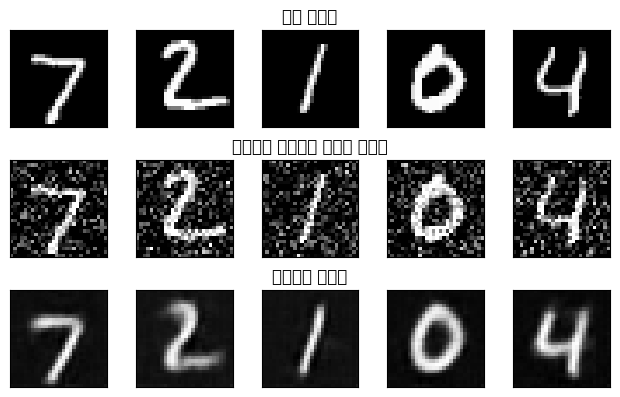

EPOCH 21/30

 EPOCH 21/30 	 train loss 0.050 	 val loss 0.038


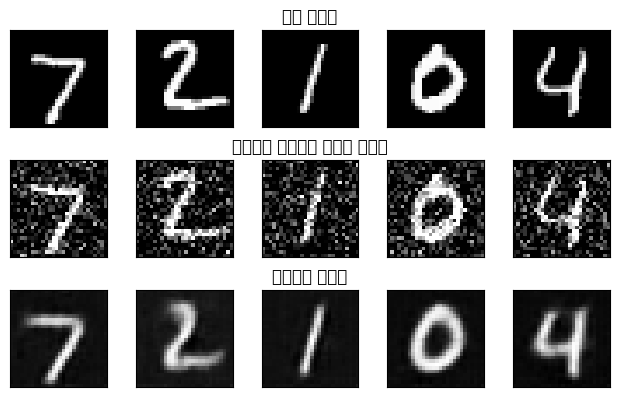

EPOCH 22/30

 EPOCH 22/30 	 train loss 0.050 	 val loss 0.038


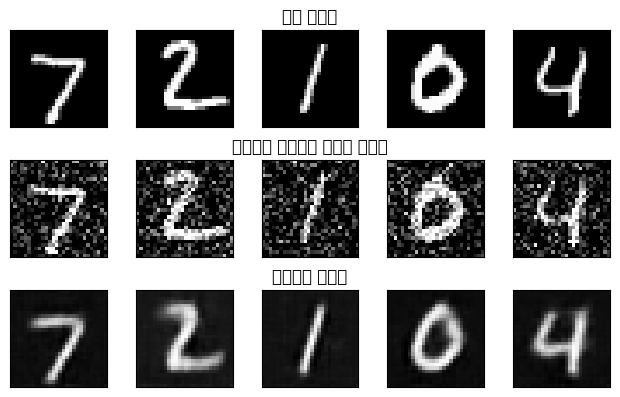

EPOCH 23/30

 EPOCH 23/30 	 train loss 0.050 	 val loss 0.038


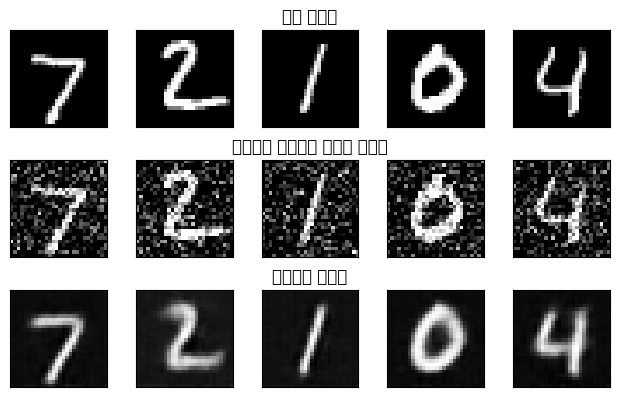

EPOCH 24/30

 EPOCH 24/30 	 train loss 0.050 	 val loss 0.038


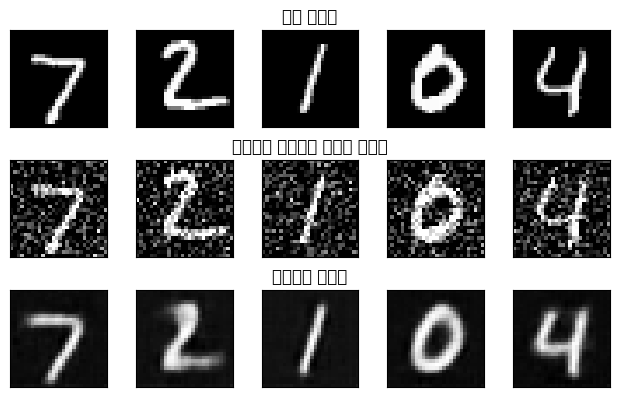

EPOCH 25/30

 EPOCH 25/30 	 train loss 0.050 	 val loss 0.038


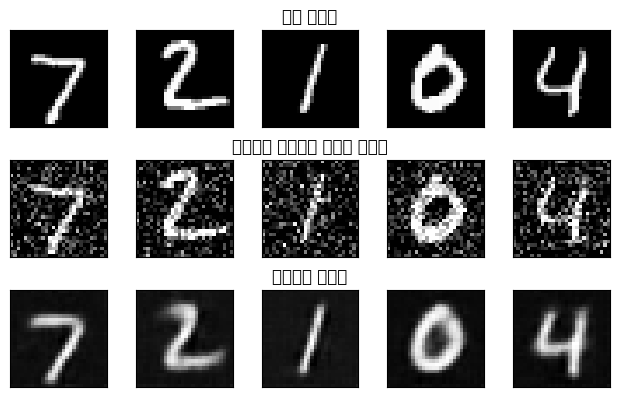

EPOCH 26/30

 EPOCH 26/30 	 train loss 0.050 	 val loss 0.038


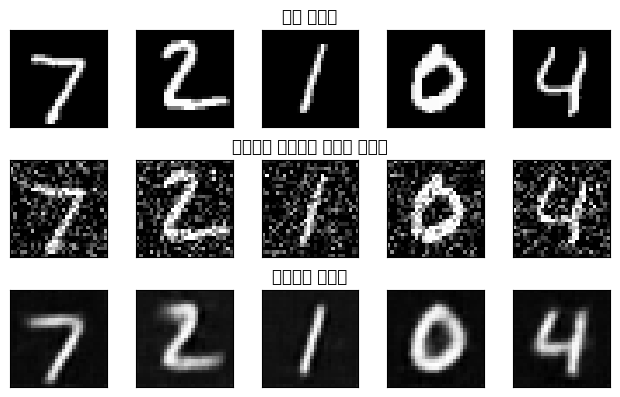

EPOCH 27/30

 EPOCH 27/30 	 train loss 0.049 	 val loss 0.038


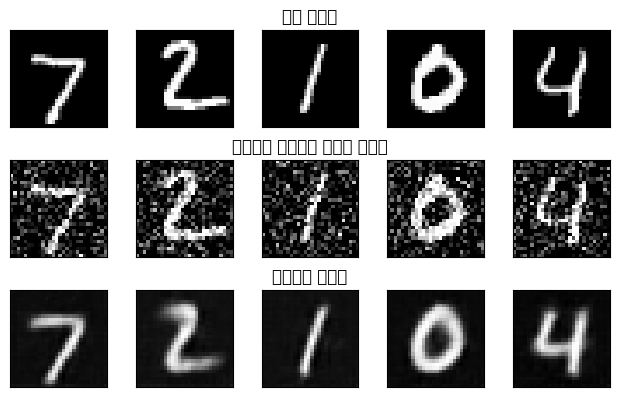

EPOCH 28/30

 EPOCH 28/30 	 train loss 0.049 	 val loss 0.038


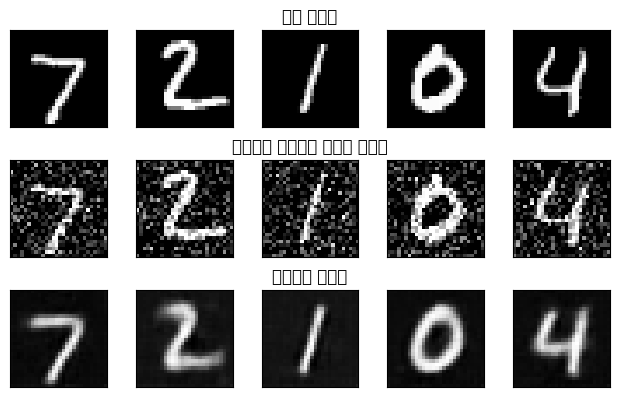

EPOCH 29/30

 EPOCH 29/30 	 train loss 0.049 	 val loss 0.038


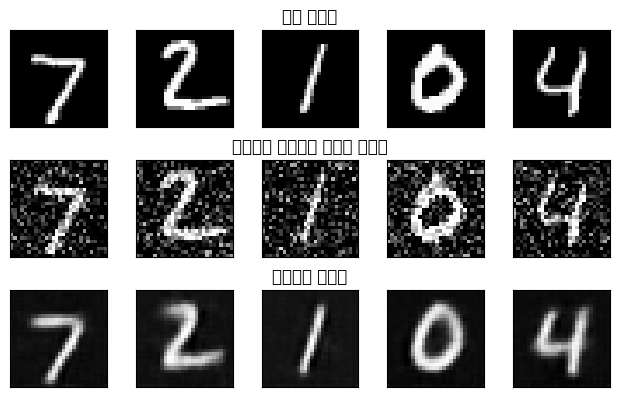

EPOCH 30/30

 EPOCH 30/30 	 train loss 0.049 	 val loss 0.038


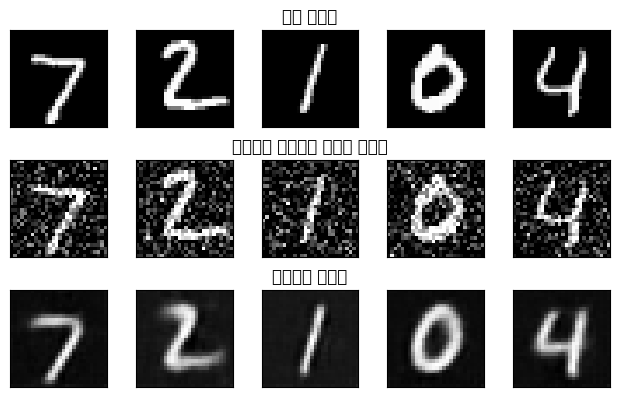

In [37]:
import numpy as np

num_epochs = 30
history_da = {'train_loss':[],'val_loss':[]}
loss_fn = torch.nn.MSELoss()

for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch+1, num_epochs))
    train_loss = train_epoch(
        encoder=encoder,
        decoder=decoder,
        device=device,
        dataloader=train_loader,
        loss_fn=loss_fn,
        optimizer=optim, noise_factor=0.3)
    val_loss = test_epoch(
        encoder=encoder,
        decoder=decoder,
        device=device,
        dataloader=test_loader,
        loss_fn=loss_fn, noise_factor=0.3)
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch+1,num_epochs, train_loss, val_loss))
    plot_ae_outputs(encoder, decoder, noise_factor=0.3)

### VAE

In [39]:
import datetime
import os
from tensorboardX import SummaryWriter

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [40]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(
    root="../chap13/data", train=True, transform=transform, download=True)

test_dataset = datasets.MNIST(
    root="../chap13/data", train=False, transform=transform, download=True)

train_loader = DataLoader(
    train_dataset, batch_size=100, shuffle=True, num_workers=4, pin_memory=False)

test_loader = DataLoader(
    test_dataset, batch_size=100, shuffle=False, num_workers=4)

In [41]:
class Encoder(nn.Module):
    def __init__(self,input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.input1 = nn.Linear(input_dim, hidden_dim)
        self.input2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear(hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True
        
    def forward(self,x):
        h_ = self.LeakyReLU(self.input1(x))
        h_ = self.LeakyReLU(self.input2(h_))
        mean = self.mean(h_)
        log_var = self.var(h_)
        return mean, log_var

In [42]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self,x):
        h = self.LeakyReLU(self.hidden1(x))
        h = self.LeakyReLU(self.hidden2(h))
        x_hat = torch.sigmoid(self.output(h))
        return x_hat

In [43]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var*epsilon
        return z
    
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5*log_var))
        x_hat = self.Decoder(z)
        return x_hat, mean, log_var

In [44]:
x_dim = 784
hidden_dim = 400
latent_dim = 200
epochs = 30
batch_size = 100

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)

model=Model(Encoder=encoder, Decoder=decoder).to(device)

In [49]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5*torch.sum(1+log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss, KLD

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [50]:
saved_loc = 'scalar/'
writer = SummaryWriter(saved_loc)

model.train()
def train(epoch, model, train_loader, optimizer):
    train_loss = 0
    for batch_idx, (x,_) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)
        
        optimizer.zero_grad()
        x_hat, mean, log_var = model(x)
        BCE, KLD = loss_function(x, x_hat, mean, log_var)
        loss = BCE + KLD
        writer.add_scalar("Train/Reconstruction Error", BCE.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        writer.add_scalar("Train/KL-Divergence", KLD.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        writer.add_scalar("Train/Total Loss" , loss.item(), batch_idx + epoch * (len(train_loader.dataset)/batch_size) )
        
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(epoch, batch_idx*len(x), len(train_loader.dataset), 
                                                                            100.*batch_idx / len(train_loader),
                                                                           loss.item() / len(x)))
            
    print("=======> Epoch: {} Average loss: {:.4f}".format(epoch, train_loss / len(train_loader.dataset)))

In [51]:
def test(epoch, model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(test_loader):
            x = x.view(batch_size, x_dim)
            x = x.to(device)        
            x_hat, mean, log_var = model(x)
            BCE, KLD = loss_function(x, x_hat, mean, log_var)
            loss = BCE + KLD
        
            writer.add_scalar("Test/Reconstruction Error", BCE.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            writer.add_scalar("Test/KL-Divergence", KLD.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            writer.add_scalar("Test/Total Loss" , loss.item(), batch_idx + epoch * (len(test_loader.dataset)/batch_size) )
            test_loss += loss.item()

            if batch_idx == 0:
                n = min(x.size(0), 8)
                comparison = torch.cat([x[:n], x_hat.view(batch_size, x_dim)[:n]])
                grid = torchvision.utils.make_grid(comparison.cpu()) 
                writer.add_image("Test image - Above: Real data, below: reconstruction data", grid, epoch)

In [52]:
from tqdm.auto import tqdm
for epoch in tqdm(range(0, epochs)):
    train(epoch, model, train_loader, optimizer)
    test(epoch, model, test_loader)
    print("\n")
writer.close()

  0%|          | 0/30 [00:00<?, ?it/s]

Train Epoch: 0 [0/60000 (0%)]	 Loss: 544.890000
Train Epoch: 0 [10000/60000 (17%)]	 Loss: 205.330488
Train Epoch: 0 [20000/60000 (33%)]	 Loss: 182.255977
Train Epoch: 0 [30000/60000 (50%)]	 Loss: 166.004238
Train Epoch: 0 [40000/60000 (67%)]	 Loss: 150.420908
Train Epoch: 0 [50000/60000 (83%)]	 Loss: 153.255293
=======> Epoch: 0 Average loss: 174.1145


Train Epoch: 1 [0/60000 (0%)]	 Loss: 134.645156
Train Epoch: 1 [10000/60000 (17%)]	 Loss: 134.169805
Train Epoch: 1 [20000/60000 (33%)]	 Loss: 137.395830
Train Epoch: 1 [30000/60000 (50%)]	 Loss: 127.294160
Train Epoch: 1 [40000/60000 (67%)]	 Loss: 128.102861
Train Epoch: 1 [50000/60000 (83%)]	 Loss: 129.143486
=======> Epoch: 1 Average loss: 128.5583


Train Epoch: 2 [0/60000 (0%)]	 Loss: 117.784590
Train Epoch: 2 [10000/60000 (17%)]	 Loss: 121.928164
Train Epoch: 2 [20000/60000 (33%)]	 Loss: 118.202275
Train Epoch: 2 [30000/60000 (50%)]	 Loss: 117.273994
Train Epoch: 2 [40000/60000 (67%)]	 Loss: 118.846074
Train Epoch: 2 [50000/60000 

=======> Epoch: 22 Average loss: 100.9967


Train Epoch: 23 [0/60000 (0%)]	 Loss: 104.301387
Train Epoch: 23 [10000/60000 (17%)]	 Loss: 96.044434
Train Epoch: 23 [20000/60000 (33%)]	 Loss: 102.812881
Train Epoch: 23 [30000/60000 (50%)]	 Loss: 103.487168
Train Epoch: 23 [40000/60000 (67%)]	 Loss: 101.637031
Train Epoch: 23 [50000/60000 (83%)]	 Loss: 101.873301
=======> Epoch: 23 Average loss: 100.8242


Train Epoch: 24 [0/60000 (0%)]	 Loss: 103.279199
Train Epoch: 24 [10000/60000 (17%)]	 Loss: 99.310566
Train Epoch: 24 [20000/60000 (33%)]	 Loss: 103.457686
Train Epoch: 24 [30000/60000 (50%)]	 Loss: 99.011553
Train Epoch: 24 [40000/60000 (67%)]	 Loss: 97.315195
Train Epoch: 24 [50000/60000 (83%)]	 Loss: 98.994668
=======> Epoch: 24 Average loss: 100.7659


Train Epoch: 25 [0/60000 (0%)]	 Loss: 101.877188
Train Epoch: 25 [10000/60000 (17%)]	 Loss: 102.530840
Train Epoch: 25 [20000/60000 (33%)]	 Loss: 99.694971
Train Epoch: 25 [30000/60000 (50%)]	 Loss: 100.663379
Train Epoch: 25 [40000/60

In [53]:
%load_ext tensorboard
%tensorboard --logdir scalar --port=6013

## GAN

In [59]:
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib
import matplotlib.pyplot as plt

from torchvision.utils import make_grid, save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
matplotlib.style.use('ggplot')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [60]:
batch_size = 512
epochs = 200
sample_size = 64 
nz = 128 
k = 1 

In [61]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])

train_dataset = datasets.MNIST(
    root="../chap13/data", train=True, transform=transform, download=True)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [65]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024,784),
            nn.Tanh()
        )
        
    def forward(self,x):
        return self.main(x).view(-1,1,28,28)

In [68]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256,1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.view(-1,784)
        return self.main(x)

In [69]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print(generator)
print(discriminator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [70]:
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

losses_g = [] 
losses_d = [] 
images = [] 

In [71]:
def save_generator_image(image, path):
    save_image(image, path)

In [72]:
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = torch.ones(b_size, 1).to(device)
    fake_label = torch.zeros(b_size, 1).to(device)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake

In [73]:
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)    
    real_label = torch.ones(b_size, 1).to(device)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [75]:
generator.train()
discriminator.train()

for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for idx, data in tqdm(enumerate(train_loader), total=int(len(train_dataset)/train_loader.batch_size)):
        image, _ = data
        image = image.to(device)
        b_size = len(image)
        for step in range(k):                                
            data_fake = generator(torch.randn(b_size, nz).to(device)).detach()
            data_real = image
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(torch.randn(b_size, nz).to(device))
        loss_g += train_generator(optim_g, data_fake)
    generated_img = generator(torch.randn(b_size, nz).to(device)).cpu().detach()
    generated_img = make_grid(generated_img)
    save_generator_image(generated_img, f"../chap13/img/gen_img{epoch}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / idx 
    epoch_loss_d = loss_d / idx 
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

118it [00:07, 15.15it/s]                                                                                               


Epoch 0 of 200
Generator loss: 2.47657442, Discriminator loss: 1.34128869


118it [00:07, 15.34it/s]                                                                                               


Epoch 1 of 200
Generator loss: 3.90585518, Discriminator loss: 0.60809803


118it [00:07, 14.89it/s]                                                                                               


Epoch 2 of 200
Generator loss: 1.48748529, Discriminator loss: 1.34383690


118it [00:07, 15.00it/s]                                                                                               


Epoch 3 of 200
Generator loss: 1.59299445, Discriminator loss: 1.18986320


118it [00:07, 15.19it/s]                                                                                               


Epoch 4 of 200
Generator loss: 1.78269577, Discriminator loss: 1.05617225


118it [00:07, 15.28it/s]                                                                                               


Epoch 5 of 200
Generator loss: 3.48151875, Discriminator loss: 1.22537816


118it [00:07, 15.61it/s]                                                                                               


Epoch 6 of 200
Generator loss: 2.76538420, Discriminator loss: 1.08584785


118it [00:07, 15.65it/s]                                                                                               


Epoch 7 of 200
Generator loss: 1.09897101, Discriminator loss: 1.09894454


118it [00:07, 15.61it/s]                                                                                               


Epoch 8 of 200
Generator loss: 0.96962917, Discriminator loss: 1.15270388


118it [00:07, 15.66it/s]                                                                                               


Epoch 9 of 200
Generator loss: 2.41446972, Discriminator loss: 0.93930435


118it [00:07, 15.74it/s]                                                                                               


Epoch 10 of 200
Generator loss: 1.71390200, Discriminator loss: 1.01730967


118it [00:07, 15.49it/s]                                                                                               


Epoch 11 of 200
Generator loss: 2.52323484, Discriminator loss: 0.82834154


118it [00:07, 15.14it/s]                                                                                               


Epoch 12 of 200
Generator loss: 2.19032121, Discriminator loss: 0.73653787


118it [00:07, 15.39it/s]                                                                                               


Epoch 13 of 200
Generator loss: 1.92540991, Discriminator loss: 0.68983579


118it [00:07, 15.08it/s]                                                                                               


Epoch 14 of 200
Generator loss: 2.73269725, Discriminator loss: 0.45059204


118it [00:08, 14.70it/s]                                                                                               


Epoch 15 of 200
Generator loss: 3.11898756, Discriminator loss: 0.42577624


118it [00:08, 14.73it/s]                                                                                               


Epoch 16 of 200
Generator loss: 2.99196982, Discriminator loss: 0.41939092


118it [00:08, 14.73it/s]                                                                                               


Epoch 17 of 200
Generator loss: 3.21216798, Discriminator loss: 0.43792617


118it [00:08, 13.76it/s]                                                                                               


Epoch 18 of 200
Generator loss: 3.21108198, Discriminator loss: 0.49953932


118it [00:07, 14.76it/s]                                                                                               


Epoch 19 of 200
Generator loss: 3.18353605, Discriminator loss: 0.51548457


118it [00:07, 14.88it/s]                                                                                               


Epoch 20 of 200
Generator loss: 3.13470411, Discriminator loss: 0.39302599


118it [00:08, 14.41it/s]                                                                                               


Epoch 21 of 200
Generator loss: 3.68670297, Discriminator loss: 0.38285160


118it [00:08, 14.48it/s]                                                                                               


Epoch 22 of 200
Generator loss: 2.70160985, Discriminator loss: 0.51503772


118it [00:07, 15.31it/s]                                                                                               


Epoch 23 of 200
Generator loss: 3.00578547, Discriminator loss: 0.46041930


118it [00:07, 15.40it/s]                                                                                               


Epoch 24 of 200
Generator loss: 3.08714819, Discriminator loss: 0.51342428


118it [00:07, 15.31it/s]                                                                                               


Epoch 25 of 200
Generator loss: 3.05173922, Discriminator loss: 0.47273412


118it [00:08, 14.07it/s]                                                                                               


Epoch 26 of 200
Generator loss: 2.77929068, Discriminator loss: 0.50518125


118it [00:07, 15.11it/s]                                                                                               


Epoch 27 of 200
Generator loss: 3.12528157, Discriminator loss: 0.52986169


118it [00:07, 14.93it/s]                                                                                               


Epoch 28 of 200
Generator loss: 3.26952648, Discriminator loss: 0.54985005


118it [00:07, 15.11it/s]                                                                                               


Epoch 29 of 200
Generator loss: 3.40017319, Discriminator loss: 0.43902558


118it [00:07, 15.01it/s]                                                                                               


Epoch 30 of 200
Generator loss: 3.11086917, Discriminator loss: 0.51277840


118it [00:07, 15.04it/s]                                                                                               


Epoch 31 of 200
Generator loss: 3.27896762, Discriminator loss: 0.44744906


118it [00:07, 15.06it/s]                                                                                               


Epoch 32 of 200
Generator loss: 3.11462307, Discriminator loss: 0.50220418


118it [00:07, 15.26it/s]                                                                                               


Epoch 33 of 200
Generator loss: 2.81034899, Discriminator loss: 0.52934301


118it [00:07, 15.31it/s]                                                                                               


Epoch 34 of 200
Generator loss: 2.67972040, Discriminator loss: 0.60997093


118it [00:07, 15.16it/s]                                                                                               


Epoch 35 of 200
Generator loss: 2.84523726, Discriminator loss: 0.51074290


118it [00:07, 15.13it/s]                                                                                               


Epoch 36 of 200
Generator loss: 3.13700509, Discriminator loss: 0.43437946


118it [00:07, 15.24it/s]                                                                                               


Epoch 37 of 200
Generator loss: 3.32895517, Discriminator loss: 0.43399322


118it [00:07, 15.37it/s]                                                                                               


Epoch 38 of 200
Generator loss: 3.80803680, Discriminator loss: 0.40652260


118it [00:07, 15.58it/s]                                                                                               


Epoch 39 of 200
Generator loss: 3.44330478, Discriminator loss: 0.45229343


118it [00:07, 15.31it/s]                                                                                               


Epoch 40 of 200
Generator loss: 3.31915498, Discriminator loss: 0.48025420


118it [00:07, 15.42it/s]                                                                                               


Epoch 41 of 200
Generator loss: 3.27386069, Discriminator loss: 0.48227569


118it [00:07, 15.07it/s]                                                                                               


Epoch 42 of 200
Generator loss: 3.02789688, Discriminator loss: 0.48541462


118it [00:07, 15.34it/s]                                                                                               


Epoch 43 of 200
Generator loss: 2.98964238, Discriminator loss: 0.53670806


118it [00:07, 15.31it/s]                                                                                               


Epoch 44 of 200
Generator loss: 3.21392107, Discriminator loss: 0.46169597


118it [00:07, 15.34it/s]                                                                                               


Epoch 45 of 200
Generator loss: 2.88200164, Discriminator loss: 0.57572168


118it [00:07, 15.54it/s]                                                                                               


Epoch 46 of 200
Generator loss: 3.16511011, Discriminator loss: 0.47394961


118it [00:07, 15.34it/s]                                                                                               


Epoch 47 of 200
Generator loss: 2.98768854, Discriminator loss: 0.52800423


118it [00:07, 15.51it/s]                                                                                               


Epoch 48 of 200
Generator loss: 3.13532782, Discriminator loss: 0.55246896


118it [00:07, 15.51it/s]                                                                                               


Epoch 49 of 200
Generator loss: 2.94645619, Discriminator loss: 0.49540469


118it [00:07, 15.71it/s]                                                                                               


Epoch 50 of 200
Generator loss: 2.98521090, Discriminator loss: 0.48103961


118it [00:07, 15.56it/s]                                                                                               


Epoch 51 of 200
Generator loss: 3.02649355, Discriminator loss: 0.50123107


118it [00:07, 15.26it/s]                                                                                               


Epoch 52 of 200
Generator loss: 2.86179519, Discriminator loss: 0.56232548


118it [00:08, 14.71it/s]                                                                                               


Epoch 53 of 200
Generator loss: 2.99424148, Discriminator loss: 0.49570772


118it [00:07, 15.50it/s]                                                                                               


Epoch 54 of 200
Generator loss: 3.06587577, Discriminator loss: 0.52511293


118it [00:07, 15.53it/s]                                                                                               


Epoch 55 of 200
Generator loss: 2.95399809, Discriminator loss: 0.51792455


118it [00:07, 15.69it/s]                                                                                               


Epoch 56 of 200
Generator loss: 2.77438807, Discriminator loss: 0.51460505


118it [00:07, 15.57it/s]                                                                                               


Epoch 57 of 200
Generator loss: 2.86281490, Discriminator loss: 0.53916985


118it [00:07, 15.64it/s]                                                                                               


Epoch 58 of 200
Generator loss: 2.84847689, Discriminator loss: 0.51948321


118it [00:07, 15.66it/s]                                                                                               


Epoch 59 of 200
Generator loss: 2.66103721, Discriminator loss: 0.57680702


118it [00:07, 15.44it/s]                                                                                               


Epoch 60 of 200
Generator loss: 2.72518325, Discriminator loss: 0.55288321


118it [00:07, 15.66it/s]                                                                                               


Epoch 61 of 200
Generator loss: 2.55817866, Discriminator loss: 0.56365728


118it [00:07, 14.84it/s]                                                                                               


Epoch 62 of 200
Generator loss: 2.49255061, Discriminator loss: 0.59737062


118it [00:07, 15.35it/s]                                                                                               


Epoch 63 of 200
Generator loss: 2.52182961, Discriminator loss: 0.59255576


118it [00:07, 15.42it/s]                                                                                               


Epoch 64 of 200
Generator loss: 2.51113462, Discriminator loss: 0.60756290


118it [00:07, 15.28it/s]                                                                                               


Epoch 65 of 200
Generator loss: 2.49626946, Discriminator loss: 0.58355945


118it [00:07, 15.48it/s]                                                                                               


Epoch 66 of 200
Generator loss: 2.42019463, Discriminator loss: 0.62257880


118it [00:07, 15.48it/s]                                                                                               


Epoch 67 of 200
Generator loss: 2.42894292, Discriminator loss: 0.64505088


118it [00:07, 15.07it/s]                                                                                               


Epoch 68 of 200
Generator loss: 2.35998750, Discriminator loss: 0.64266378


118it [00:07, 15.10it/s]                                                                                               


Epoch 69 of 200
Generator loss: 2.44201469, Discriminator loss: 0.62975585


118it [00:07, 15.15it/s]                                                                                               


Epoch 70 of 200
Generator loss: 2.49351692, Discriminator loss: 0.63270926


118it [00:07, 15.29it/s]                                                                                               


Epoch 71 of 200
Generator loss: 2.34887886, Discriminator loss: 0.65388912


118it [00:07, 15.28it/s]                                                                                               


Epoch 72 of 200
Generator loss: 2.30799866, Discriminator loss: 0.68605679


118it [00:07, 15.46it/s]                                                                                               


Epoch 73 of 200
Generator loss: 2.33991957, Discriminator loss: 0.67204487


118it [00:07, 15.31it/s]                                                                                               


Epoch 74 of 200
Generator loss: 2.42624712, Discriminator loss: 0.64787894


118it [00:07, 15.58it/s]                                                                                               


Epoch 75 of 200
Generator loss: 2.31228828, Discriminator loss: 0.67659354


118it [00:07, 15.32it/s]                                                                                               


Epoch 76 of 200
Generator loss: 2.35998201, Discriminator loss: 0.68726444


118it [00:07, 15.37it/s]                                                                                               


Epoch 77 of 200
Generator loss: 2.36755490, Discriminator loss: 0.66799605


118it [00:08, 14.32it/s]                                                                                               


Epoch 78 of 200
Generator loss: 2.30974507, Discriminator loss: 0.69382536


118it [00:07, 15.09it/s]                                                                                               


Epoch 79 of 200
Generator loss: 2.20539975, Discriminator loss: 0.74030316


118it [00:07, 15.43it/s]                                                                                               


Epoch 80 of 200
Generator loss: 2.15040064, Discriminator loss: 0.73817337


118it [00:07, 15.64it/s]                                                                                               


Epoch 81 of 200
Generator loss: 2.20583558, Discriminator loss: 0.73561007


118it [00:07, 15.53it/s]                                                                                               


Epoch 82 of 200
Generator loss: 2.23840451, Discriminator loss: 0.71750546


118it [00:07, 15.54it/s]                                                                                               


Epoch 83 of 200
Generator loss: 2.23127747, Discriminator loss: 0.68011445


118it [00:07, 15.44it/s]                                                                                               


Epoch 84 of 200
Generator loss: 2.16219521, Discriminator loss: 0.70535505


118it [00:07, 15.49it/s]                                                                                               


Epoch 85 of 200
Generator loss: 2.24780393, Discriminator loss: 0.70658541


118it [00:07, 15.40it/s]                                                                                               


Epoch 86 of 200
Generator loss: 2.08730030, Discriminator loss: 0.75265545


118it [00:07, 15.53it/s]                                                                                               


Epoch 87 of 200
Generator loss: 2.15004730, Discriminator loss: 0.72949827


118it [00:07, 15.43it/s]                                                                                               


Epoch 88 of 200
Generator loss: 2.09235239, Discriminator loss: 0.74014533


118it [00:07, 15.47it/s]                                                                                               


Epoch 89 of 200
Generator loss: 2.13212967, Discriminator loss: 0.70382315


118it [00:07, 15.64it/s]                                                                                               


Epoch 90 of 200
Generator loss: 2.19887233, Discriminator loss: 0.72683316


118it [00:07, 15.17it/s]                                                                                               


Epoch 91 of 200
Generator loss: 2.09022355, Discriminator loss: 0.72152215


118it [00:07, 15.25it/s]                                                                                               


Epoch 92 of 200
Generator loss: 2.08525705, Discriminator loss: 0.76320142


118it [00:07, 15.12it/s]                                                                                               


Epoch 93 of 200
Generator loss: 2.08692193, Discriminator loss: 0.78407228


118it [00:07, 15.43it/s]                                                                                               


Epoch 94 of 200
Generator loss: 1.98935032, Discriminator loss: 0.78796095


118it [00:07, 15.48it/s]                                                                                               


Epoch 95 of 200
Generator loss: 2.00437021, Discriminator loss: 0.77009875


118it [00:07, 15.75it/s]                                                                                               


Epoch 96 of 200
Generator loss: 2.01241159, Discriminator loss: 0.75331342


118it [00:07, 15.54it/s]                                                                                               


Epoch 97 of 200
Generator loss: 2.00280523, Discriminator loss: 0.79542649


118it [00:07, 15.63it/s]                                                                                               


Epoch 98 of 200
Generator loss: 1.99516094, Discriminator loss: 0.77120876


118it [00:07, 15.39it/s]                                                                                               


Epoch 99 of 200
Generator loss: 1.94496989, Discriminator loss: 0.79121518


118it [00:07, 15.68it/s]                                                                                               


Epoch 100 of 200
Generator loss: 2.03744340, Discriminator loss: 0.79368407


118it [00:07, 15.44it/s]                                                                                               


Epoch 101 of 200
Generator loss: 1.98450410, Discriminator loss: 0.81339276


118it [00:07, 15.51it/s]                                                                                               


Epoch 102 of 200
Generator loss: 1.91427648, Discriminator loss: 0.79413444


118it [00:07, 15.66it/s]                                                                                               


Epoch 103 of 200
Generator loss: 1.84530628, Discriminator loss: 0.84657955


118it [00:07, 15.69it/s]                                                                                               


Epoch 104 of 200
Generator loss: 1.86144030, Discriminator loss: 0.82670456


118it [00:07, 15.36it/s]                                                                                               


Epoch 105 of 200
Generator loss: 1.90965426, Discriminator loss: 0.82748860


118it [00:07, 15.71it/s]                                                                                               


Epoch 106 of 200
Generator loss: 1.85652637, Discriminator loss: 0.83510238


118it [00:07, 15.41it/s]                                                                                               


Epoch 107 of 200
Generator loss: 1.88170159, Discriminator loss: 0.81506556


118it [00:07, 15.58it/s]                                                                                               


Epoch 108 of 200
Generator loss: 1.84013867, Discriminator loss: 0.83208096


118it [00:07, 15.67it/s]                                                                                               


Epoch 109 of 200
Generator loss: 1.79030752, Discriminator loss: 0.84964913


118it [00:07, 15.46it/s]                                                                                               


Epoch 110 of 200
Generator loss: 1.80859435, Discriminator loss: 0.82875383


118it [00:07, 15.52it/s]                                                                                               


Epoch 111 of 200
Generator loss: 1.79466045, Discriminator loss: 0.83972293


118it [00:07, 15.57it/s]                                                                                               


Epoch 112 of 200
Generator loss: 1.79891825, Discriminator loss: 0.85659373


118it [00:07, 15.59it/s]                                                                                               


Epoch 113 of 200
Generator loss: 1.73624849, Discriminator loss: 0.88290244


118it [00:07, 15.66it/s]                                                                                               


Epoch 114 of 200
Generator loss: 1.83308744, Discriminator loss: 0.85416430


118it [00:07, 15.69it/s]                                                                                               


Epoch 115 of 200
Generator loss: 1.75345647, Discriminator loss: 0.87264884


118it [00:07, 15.57it/s]                                                                                               


Epoch 116 of 200
Generator loss: 1.76963055, Discriminator loss: 0.88310468


118it [00:07, 15.54it/s]                                                                                               


Epoch 117 of 200
Generator loss: 1.72650719, Discriminator loss: 0.88626915


118it [00:07, 15.85it/s]                                                                                               


Epoch 118 of 200
Generator loss: 1.65421152, Discriminator loss: 0.91416538


118it [00:07, 15.66it/s]                                                                                               


Epoch 119 of 200
Generator loss: 1.66332269, Discriminator loss: 0.91346163


118it [00:07, 15.85it/s]                                                                                               


Epoch 120 of 200
Generator loss: 1.70290399, Discriminator loss: 0.89855015


118it [00:07, 15.67it/s]                                                                                               


Epoch 121 of 200
Generator loss: 1.61793172, Discriminator loss: 0.92480725


118it [00:07, 15.54it/s]                                                                                               


Epoch 122 of 200
Generator loss: 1.70123768, Discriminator loss: 0.90346718


118it [00:07, 15.65it/s]                                                                                               


Epoch 123 of 200
Generator loss: 1.66986048, Discriminator loss: 0.90253997


118it [00:07, 15.05it/s]                                                                                               


Epoch 124 of 200
Generator loss: 1.66563594, Discriminator loss: 0.90993267


118it [00:07, 14.88it/s]                                                                                               


Epoch 125 of 200
Generator loss: 1.75008261, Discriminator loss: 0.89437687


118it [00:07, 15.52it/s]                                                                                               


Epoch 126 of 200
Generator loss: 1.66283345, Discriminator loss: 0.89629310


118it [00:07, 15.69it/s]                                                                                               


Epoch 127 of 200
Generator loss: 1.64475191, Discriminator loss: 0.91910708


118it [00:07, 15.73it/s]                                                                                               


Epoch 128 of 200
Generator loss: 1.64212275, Discriminator loss: 0.92514634


118it [00:07, 15.53it/s]                                                                                               


Epoch 129 of 200
Generator loss: 1.62299979, Discriminator loss: 0.94061518


118it [00:07, 15.87it/s]                                                                                               


Epoch 130 of 200
Generator loss: 1.66955292, Discriminator loss: 0.90399116


118it [00:07, 15.68it/s]                                                                                               


Epoch 131 of 200
Generator loss: 1.58468390, Discriminator loss: 0.93561316


118it [00:07, 15.79it/s]                                                                                               


Epoch 132 of 200
Generator loss: 1.56425440, Discriminator loss: 0.95171177


118it [00:07, 15.71it/s]                                                                                               


Epoch 133 of 200
Generator loss: 1.57158530, Discriminator loss: 0.94886506


118it [00:07, 15.80it/s]                                                                                               


Epoch 134 of 200
Generator loss: 1.55883992, Discriminator loss: 0.93962342


118it [00:07, 15.63it/s]                                                                                               


Epoch 135 of 200
Generator loss: 1.66327131, Discriminator loss: 0.92225087


118it [00:07, 15.68it/s]                                                                                               


Epoch 136 of 200
Generator loss: 1.63041461, Discriminator loss: 0.93440354


118it [00:07, 15.69it/s]                                                                                               


Epoch 137 of 200
Generator loss: 1.58017409, Discriminator loss: 0.93001246


118it [00:07, 15.73it/s]                                                                                               


Epoch 138 of 200
Generator loss: 1.58549428, Discriminator loss: 0.93669897


118it [00:07, 15.55it/s]                                                                                               


Epoch 139 of 200
Generator loss: 1.58487868, Discriminator loss: 0.96993816


118it [00:07, 15.54it/s]                                                                                               


Epoch 140 of 200
Generator loss: 1.48495281, Discriminator loss: 0.98918629


118it [00:07, 15.87it/s]                                                                                               


Epoch 141 of 200
Generator loss: 1.52004266, Discriminator loss: 0.97311330


118it [00:07, 15.79it/s]                                                                                               


Epoch 142 of 200
Generator loss: 1.45233679, Discriminator loss: 0.97583288


118it [00:07, 15.81it/s]                                                                                               


Epoch 143 of 200
Generator loss: 1.51576591, Discriminator loss: 0.96964777


118it [00:07, 15.90it/s]                                                                                               


Epoch 144 of 200
Generator loss: 1.54920578, Discriminator loss: 0.96323568


118it [00:07, 15.62it/s]                                                                                               


Epoch 145 of 200
Generator loss: 1.56930721, Discriminator loss: 0.93332928


118it [00:07, 15.25it/s]                                                                                               


Epoch 146 of 200
Generator loss: 1.56610191, Discriminator loss: 0.96497548


118it [00:07, 15.77it/s]                                                                                               


Epoch 147 of 200
Generator loss: 1.48735154, Discriminator loss: 0.99274540


118it [00:07, 15.59it/s]                                                                                               


Epoch 148 of 200
Generator loss: 1.53168416, Discriminator loss: 0.95769423


118it [00:07, 15.86it/s]                                                                                               


Epoch 149 of 200
Generator loss: 1.47422612, Discriminator loss: 0.97796357


118it [00:07, 15.60it/s]                                                                                               


Epoch 150 of 200
Generator loss: 1.46625519, Discriminator loss: 0.98681116


118it [00:07, 15.74it/s]                                                                                               


Epoch 151 of 200
Generator loss: 1.48987377, Discriminator loss: 0.99418682


118it [00:07, 15.62it/s]                                                                                               


Epoch 152 of 200
Generator loss: 1.43986237, Discriminator loss: 1.00516474


118it [00:07, 15.70it/s]                                                                                               


Epoch 153 of 200
Generator loss: 1.43306398, Discriminator loss: 1.01561582


118it [00:07, 15.86it/s]                                                                                               


Epoch 154 of 200
Generator loss: 1.45611346, Discriminator loss: 1.01624501


118it [00:07, 15.19it/s]                                                                                               


Epoch 155 of 200
Generator loss: 1.46776426, Discriminator loss: 0.98358321


118it [00:07, 15.92it/s]                                                                                               


Epoch 156 of 200
Generator loss: 1.46188998, Discriminator loss: 1.00105977


118it [00:07, 15.67it/s]                                                                                               


Epoch 157 of 200
Generator loss: 1.45740175, Discriminator loss: 0.99751920


118it [00:07, 15.97it/s]                                                                                               


Epoch 158 of 200
Generator loss: 1.45583892, Discriminator loss: 0.99702287


118it [00:07, 15.95it/s]                                                                                               


Epoch 159 of 200
Generator loss: 1.41807544, Discriminator loss: 1.02310908


118it [00:07, 15.53it/s]                                                                                               


Epoch 160 of 200
Generator loss: 1.38234508, Discriminator loss: 1.01884210


118it [00:07, 15.58it/s]                                                                                               


Epoch 161 of 200
Generator loss: 1.39211988, Discriminator loss: 1.03245056


118it [00:07, 15.69it/s]                                                                                               


Epoch 162 of 200
Generator loss: 1.39380240, Discriminator loss: 1.04432881


118it [00:07, 15.77it/s]                                                                                               


Epoch 163 of 200
Generator loss: 1.33075118, Discriminator loss: 1.05649662


118it [00:07, 15.81it/s]                                                                                               


Epoch 164 of 200
Generator loss: 1.40401697, Discriminator loss: 1.01982582


118it [00:07, 15.61it/s]                                                                                               


Epoch 165 of 200
Generator loss: 1.43450522, Discriminator loss: 1.02663040


118it [00:07, 15.60it/s]                                                                                               


Epoch 166 of 200
Generator loss: 1.37359858, Discriminator loss: 1.03534484


118it [00:07, 15.76it/s]                                                                                               


Epoch 167 of 200
Generator loss: 1.40926933, Discriminator loss: 1.02164233


118it [00:07, 15.86it/s]                                                                                               


Epoch 168 of 200
Generator loss: 1.39676690, Discriminator loss: 1.03822088


118it [00:07, 15.60it/s]                                                                                               


Epoch 169 of 200
Generator loss: 1.39916492, Discriminator loss: 1.01899683


118it [00:07, 15.76it/s]                                                                                               


Epoch 170 of 200
Generator loss: 1.38092148, Discriminator loss: 1.02276993


118it [00:07, 15.76it/s]                                                                                               


Epoch 171 of 200
Generator loss: 1.41593218, Discriminator loss: 1.03371179


118it [00:07, 15.91it/s]                                                                                               


Epoch 172 of 200
Generator loss: 1.40796256, Discriminator loss: 1.01017165


118it [00:07, 15.83it/s]                                                                                               


Epoch 173 of 200
Generator loss: 1.30203986, Discriminator loss: 1.07691801


118it [00:07, 15.64it/s]                                                                                               


Epoch 174 of 200
Generator loss: 1.29965389, Discriminator loss: 1.05887043


118it [00:07, 15.57it/s]                                                                                               


Epoch 175 of 200
Generator loss: 1.30580795, Discriminator loss: 1.06287253


118it [00:07, 15.74it/s]                                                                                               


Epoch 176 of 200
Generator loss: 1.30529857, Discriminator loss: 1.05673158


118it [00:07, 15.67it/s]                                                                                               


Epoch 177 of 200
Generator loss: 1.31256115, Discriminator loss: 1.05276203


118it [00:07, 15.56it/s]                                                                                               


Epoch 178 of 200
Generator loss: 1.31933260, Discriminator loss: 1.05966723


118it [00:07, 15.54it/s]                                                                                               


Epoch 179 of 200
Generator loss: 1.31093609, Discriminator loss: 1.08277512


118it [00:07, 15.51it/s]                                                                                               


Epoch 180 of 200
Generator loss: 1.27358508, Discriminator loss: 1.07337403


118it [00:07, 15.40it/s]                                                                                               


Epoch 181 of 200
Generator loss: 1.29743171, Discriminator loss: 1.06936717


118it [00:07, 15.56it/s]                                                                                               


Epoch 182 of 200
Generator loss: 1.35227716, Discriminator loss: 1.05499482


118it [00:07, 15.79it/s]                                                                                               


Epoch 183 of 200
Generator loss: 1.28950524, Discriminator loss: 1.07752180


118it [00:07, 15.73it/s]                                                                                               


Epoch 184 of 200
Generator loss: 1.32611609, Discriminator loss: 1.05382490


118it [00:07, 15.68it/s]                                                                                               


Epoch 185 of 200
Generator loss: 1.33865309, Discriminator loss: 1.06037688


118it [00:07, 15.57it/s]                                                                                               


Epoch 186 of 200
Generator loss: 1.36306548, Discriminator loss: 1.05920553


118it [00:07, 15.76it/s]                                                                                               


Epoch 187 of 200
Generator loss: 1.34887540, Discriminator loss: 1.04976773


118it [00:07, 15.89it/s]                                                                                               


Epoch 188 of 200
Generator loss: 1.37076581, Discriminator loss: 1.05090189


118it [00:07, 15.72it/s]                                                                                               


Epoch 189 of 200
Generator loss: 1.31469202, Discriminator loss: 1.06682444


118it [00:07, 15.90it/s]                                                                                               


Epoch 190 of 200
Generator loss: 1.33700252, Discriminator loss: 1.04951549


118it [00:07, 15.87it/s]                                                                                               


Epoch 191 of 200
Generator loss: 1.30957615, Discriminator loss: 1.07243824


118it [00:07, 15.62it/s]                                                                                               


Epoch 192 of 200
Generator loss: 1.32113743, Discriminator loss: 1.07582581


118it [00:07, 15.76it/s]                                                                                               


Epoch 193 of 200
Generator loss: 1.31254101, Discriminator loss: 1.07401085


118it [00:07, 15.91it/s]                                                                                               


Epoch 194 of 200
Generator loss: 1.31275189, Discriminator loss: 1.06310201


118it [00:07, 15.65it/s]                                                                                               


Epoch 195 of 200
Generator loss: 1.29675233, Discriminator loss: 1.07597601


118it [00:07, 15.78it/s]                                                                                               


Epoch 196 of 200
Generator loss: 1.33520150, Discriminator loss: 1.05873013


118it [00:07, 15.62it/s]                                                                                               


Epoch 197 of 200
Generator loss: 1.36256468, Discriminator loss: 1.06106603


118it [00:07, 15.60it/s]                                                                                               


Epoch 198 of 200
Generator loss: 1.35100830, Discriminator loss: 1.03578210


118it [00:07, 15.71it/s]                                                                                               

Epoch 199 of 200
Generator loss: 1.35041153, Discriminator loss: 1.04909754


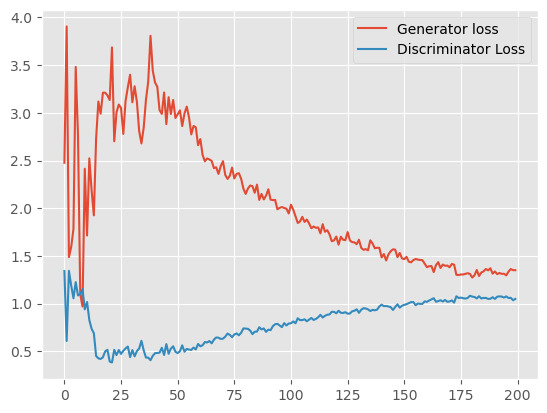

In [76]:
plt.figure()
losses_g = [fl.item() for fl in losses_g ]
plt.plot(losses_g, label='Generator loss')
losses_d = [f2.item() for f2 in losses_d ]
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()

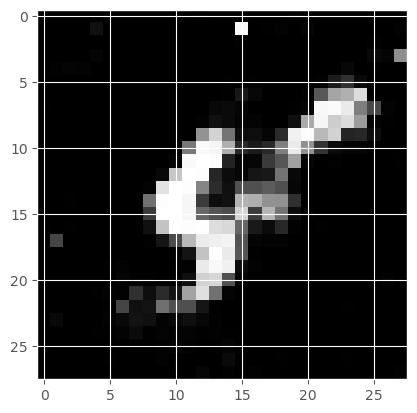

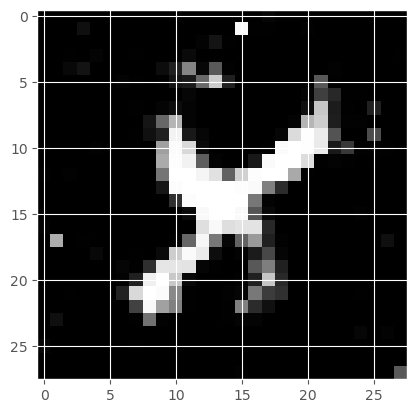

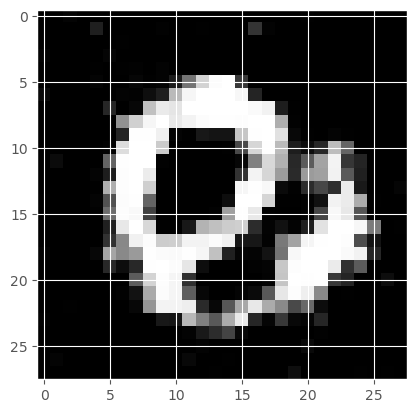

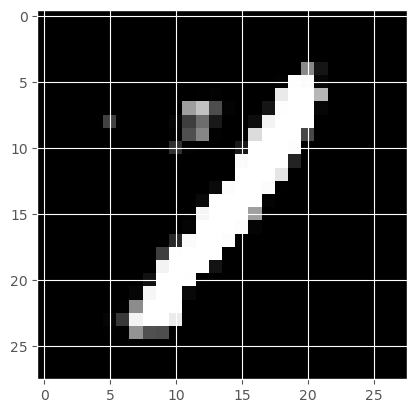

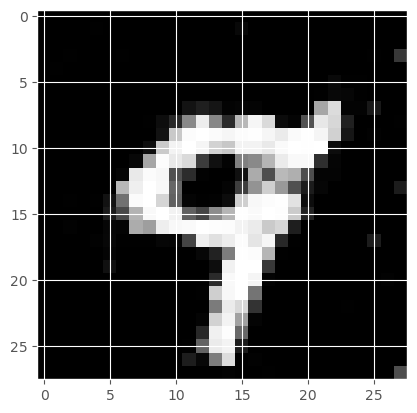

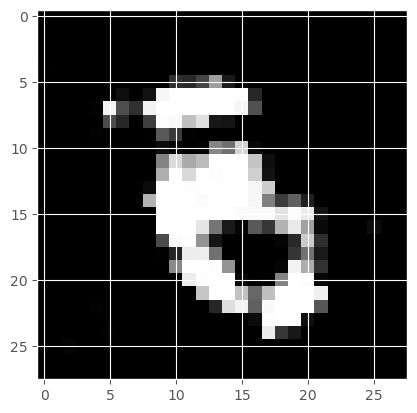

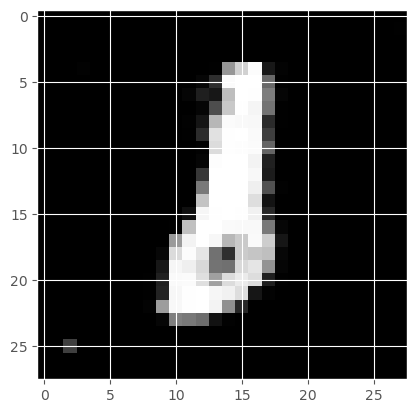

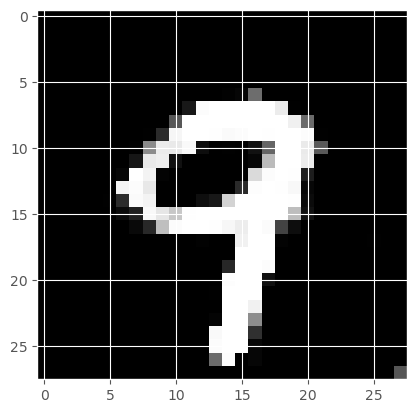

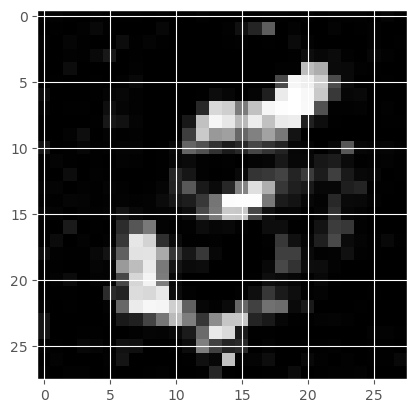

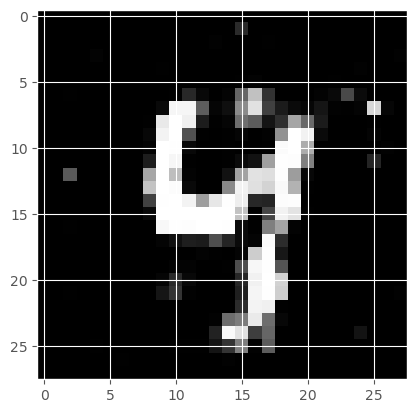

In [77]:
fake_images = generator(torch.randn(b_size, nz).to(device))
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i],(28, 28))
    plt.imshow(fake_images_img, cmap = 'gray')    
    plt.show()